In [1]:
import os
os.chdir('/Volumes/Transcend/00unzip')
import json
import ijson

import pandas as pd

In [9]:
#get 5K for testing

f = open('/Volumes/Transcend/00unzip/gab_posts_jan_2018.json')
objects = ijson.items(f,'actuser.username')

chunk=[]
username=[]
body=[]
ts=[]

i = 0
for a in f:
    line = json.loads(a)
    username.append(line['actuser']['username'])
    body.append(line['post']['body'])
    ts.append(line['published_at'])
    i = i+1
    if i > 5000:
        break
                      
df_original = pd.DataFrame(
    {'username': username,
     'body': body,
     'ts': ts
    })
df = df_original.copy
df.head()

,username,body,ts
0,Hogantwonk,What anyone thinks of guns doesn’t matter. It ...,2017-11-06T09:09:28+00:00
1,TwistedMemes,💔,2017-11-06T09:01:07+00:00
2,RealTrumpTweets,...Americans do what we do best: we pull toget...,2017-11-06T07:27:45+00:00
3,Fash_McQueen,It's becoming impossible to parody the Alt-Lit...,2017-11-06T09:09:16+00:00
4,RaviCrux,The media is complicit.\nThey embolden these l...,2017-11-06T07:15:04+00:00


In [3]:
import sys
df.to_csv('gab_snippet.csv')
#100K record is ~18mb

In [ ]:
### input

In [17]:
import nltk
import re


In [26]:
### preprocessing/ remove url
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_txt(txt):
    #remove_url
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', '', txt, flags=re.MULTILINE)
    #same lettercase
    txt = txt.lower() 
    #remove stopwords
    txt = ' '.join(word for word in txt.split() if word not in STOPWORDS)
    return txt

df['body'] = df['body'].apply(clean_txt)

In [ ]:
# further processsing - lemmetize with spacy

In [ ]:
### 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
cnt = count_vectorizer.fit_transform(df.body)
cnt_feature_names = count_vectorizer.get_feature_names()

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.body)

### SVD

In [35]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(tfidf)
dtm_lsa.shape

(5001, 2)

In [51]:
import numpy as np
tfidf_output = pd.DataFrame(np.c_[dtm_lsa, df.body])
tfidf_output.head()
tfidf_output.to_csv('tfidf_output.csv')

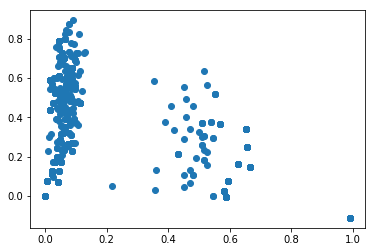

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(dtm_lsa[:,0], dtm_lsa[:,1],'o')

In [54]:
### t-SNE
from sklearn.manifold import TSNE

n_sne = 1000
tsne = TSNE(n_components=2, verbose=1, perplexity=40,
            n_iter=300, random_state=0)
X_tsne = tsne.fit_transform(tfidf)

plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()



TypeError: A sparse matrix was passed, but dense data is required for method="barnes_hut". Use X.toarray() to convert to a dense numpy array if the array is small enough for it to fit in memory. Otherwise consider dimensionality reduction techniques (e.g. TruncatedSVD)

### plotly

In [42]:
# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')